In [16]:
%cd /Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model

import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
QG_channel = 1
num_samples = 1000
batch_size = 32
num_epochs = 20
lr = 1e-3

# Load raw classical data (no quantum encoding)
filename = f"data/QG{QG_channel}_64x64_1k"
with h5py.File(filename, 'r') as f:
    X = np.array(f['X'])

# Ensure shape is (N, H, W) or (N, H, W, C)
if X.ndim == 3:
    X = X[..., np.newaxis]

# Normalize to [0,1]
X = X.astype(np.float32)
minv = X.min()
maxv = X.max()
if maxv - minv > 0:
    X = (X - minv) / (maxv - minv)

# Use a subset if dataset larger than num_samples
X = X[:num_samples]

# Convert to (N, C, H, W)
X_t = torch.tensor(X).permute(0,3,1,2)

train_X, val_X = train_test_split(X_t, test_size=0.2, random_state=42)
train_ds = TensorDataset(train_X)
val_ds = TensorDataset(val_X)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# Simpler, reliable autoencoder that preserves input size
class SimpleAutoencoder(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 64, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, in_ch, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )
    def forward(self,x):
        z = self.enc(x)
        out = self.dec(z)
        return out

# instantiate placeholder model (actual instantiation before training)
model = SimpleAutoencoder(in_ch=X_t.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

Epoch 1/20  train_loss=0.036859  val_loss=0.000129
Epoch 2/20  train_loss=0.000075  val_loss=0.000048
Epoch 3/20  train_loss=0.000039  val_loss=0.000032
Epoch 4/20  train_loss=0.000027  val_loss=0.000023
Epoch 5/20  train_loss=0.000021  val_loss=0.000018
Epoch 6/20  train_loss=0.000016  val_loss=0.000014
Epoch 7/20  train_loss=0.000012  val_loss=0.000009
Epoch 8/20  train_loss=0.000007  val_loss=0.000004
Epoch 9/20  train_loss=0.000004  val_loss=0.000003
Epoch 10/20  train_loss=0.000003  val_loss=0.000002
Epoch 11/20  train_loss=0.000002  val_loss=0.000002
Epoch 12/20  train_loss=0.000002  val_loss=0.000001
Epoch 13/20  train_loss=0.000002  val_loss=0.000001
Epoch 14/20  train_loss=0.000002  val_loss=0.000001
Epoch 15/20  train_loss=0.000002  val_loss=0.000001
Epoch 16/20  train_loss=0.000002  val_loss=0.000001
Epoch 17/20  train_loss=0.000002  val_loss=0.000001
Epoch 18/20  train_loss=0.000001  val_loss=0.000001
Epoch 19/20  train_loss=0.000001  val_loss=0.000001
Epoch 20/20  train_lo

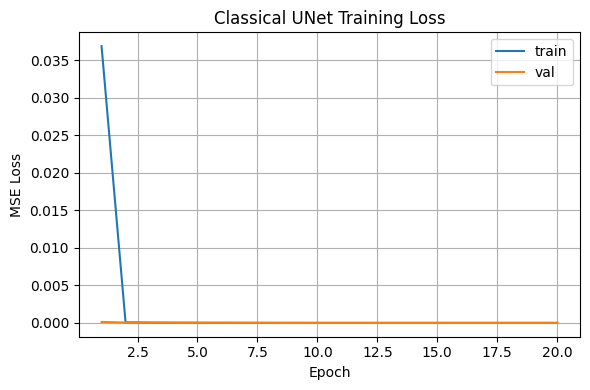

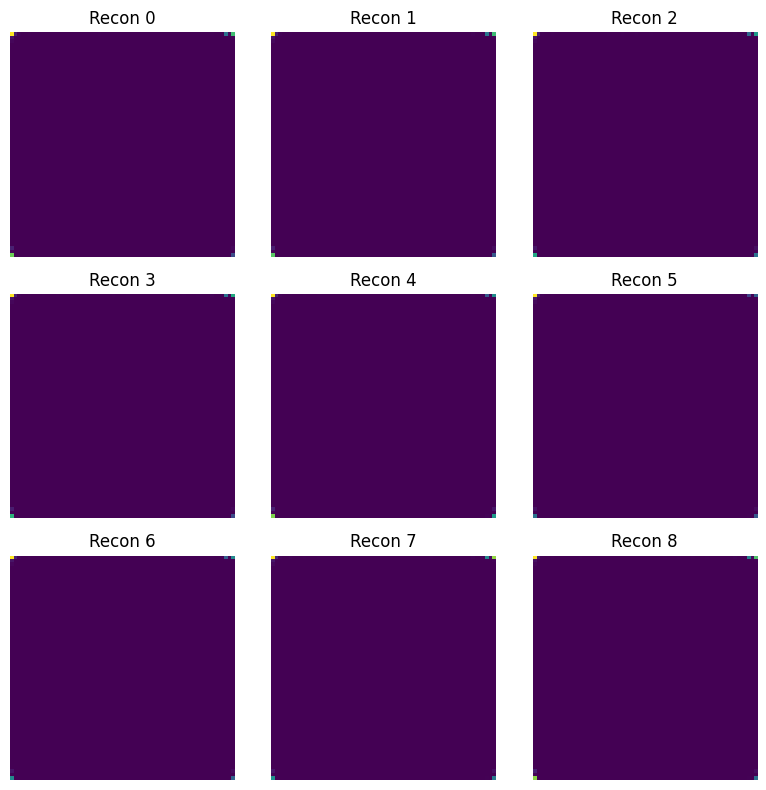

In [ ]:
# Ensure we use the SimpleAutoencoder implementation
model = SimpleAutoencoder(in_ch=X_t.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

loss_history = []
val_loss_history = []
for epoch in range(1, num_epochs+1):
    model.train()
    running = 0.0
    seen = 0
    for (batch,) in train_loader:
        batch = batch.to(device)
        # add gaussian noise for denoising task
        noisy = batch + 0.1 * torch.randn_like(batch)
        noisy = torch.clamp(noisy, 0.0, 1.0)
        pred = model(noisy)
        loss = criterion(pred, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item() * batch.size(0)
        seen += batch.size(0)
    epoch_loss = running / seen
    loss_history.append(epoch_loss)

    # validation
    model.eval()
    vrunning = 0.0
    vseen = 0
    with torch.no_grad():
        for (vbatch,) in val_loader:
            vbatch = vbatch.to(device)
            noisy = vbatch + 0.1 * torch.randn_like(vbatch)
            noisy = torch.clamp(noisy, 0.0, 1.0)
            pred = model(noisy)
            vloss = criterion(pred, vbatch)
            vrunning += vloss.item() * vbatch.size(0)
            vseen += vbatch.size(0)
    vepoch_loss = vrunning / vseen
    val_loss_history.append(vepoch_loss)

    print(f'Epoch {epoch}/{num_epochs}  train_loss={epoch_loss:.6f}  val_loss={vepoch_loss:.6f}')

# Save model and loss history
torch.save(model.state_dict(), 'saved_models/classical_unet.pth')
np.save('saved_models/classical_unet_loss.npy', np.array(loss_history))
np.save('saved_models/classical_unet_val_loss.npy', np.array(val_loss_history))

# Plot training/validation loss
plt.figure(figsize=(6,4))
plt.plot(range(1,len(loss_history)+1), loss_history, label='train')
plt.plot(range(1,len(val_loss_history)+1), val_loss_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Classical UNet Training Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/classical_unet_loss.png', dpi=150)
plt.show()

# Visualize some reconstructions from validation set
model.eval()
with torch.no_grad():
    sample_batch = val_X[:9].to(device)
    noisy = sample_batch + 0.1 * torch.randn_like(sample_batch)
    noisy = torch.clamp(noisy, 0.0, 1.0)
    recon = model(noisy).cpu()
    noisy = noisy.cpu()

fig, axs = plt.subplots(3,3, figsize=(8,8))
for i in range(9):
    img = recon[i].permute(1,2,0).squeeze()
    axs[i//3, i%3].imshow(img, cmap='viridis')
    axs[i//3, i%3].axis('off')
    axs[i//3, i%3].set_title(f'Recon {i}')
plt.tight_layout()
plt.savefig('plots/classical_unet_reconstructions.png', dpi=150)
plt.show()


/Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model/utils/statistics.py:15: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)


Validation FID: 0.0061, Mean SSIM: 0.9529


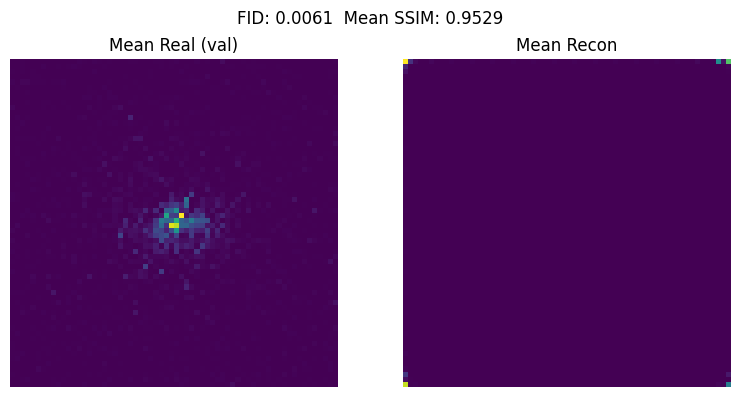

Saved metrics to saved_models/classical_unet_metrics.json


In [14]:
from utils.statistics import calculate_statistics, calculate_fid
from skimage.metrics import structural_similarity as ssim_func
import json

# Compute reconstructions for full validation set in batches
recon_list = []
model.eval()
with torch.no_grad():
    for (vbatch,) in val_loader:
        vbatch = vbatch.to(device)
        pred = model(vbatch)
        recon_list.append(pred.cpu())
if len(recon_list) == 0:
    print('No validation reconstructions computed (empty val_loader).')
else:
    recon_all = torch.cat(recon_list, dim=0).numpy()  # (N,C,H,W)
    real_all = val_X.cpu().numpy()  # (N,C,H,W)
    # convert to (N,H,W,C) for metric functions
    recon_all = recon_all.transpose(0,2,3,1)
    real_all = real_all.transpose(0,2,3,1)

    m = min(len(real_all), len(recon_all))
    mu_r, sig_r = calculate_statistics(real_all[:m])
    mu_g, sig_g = calculate_statistics(recon_all[:m])
    fid_score = calculate_fid(mu_r, sig_r, mu_g, sig_g)

    # SSIM per-sample (use mean across channels)
    ssim_scores = []
    for i in range(m):
        real_gray = np.mean(real_all[i], axis=2)
        recon_gray = np.mean(recon_all[i], axis=2)
        data_range = max(real_gray.max()-real_gray.min(), recon_gray.max()-recon_gray.min(), 1e-8)
        s = ssim_func(real_gray, recon_gray, data_range=float(data_range))
        ssim_scores.append(s)
    avg_ssim = float(np.mean(ssim_scores)) if len(ssim_scores)>0 else float('nan')

    print(f'Validation FID: {fid_score:.4f}, Mean SSIM: {avg_ssim:.4f}')

    # Mean images and plot side-by-side
    mean_real = np.mean(real_all[:m], axis=0)
    mean_recon = np.mean(recon_all[:m], axis=0)
    fig, axs = plt.subplots(1,2,figsize=(8,4))
    axs[0].imshow(np.mean(mean_real, axis=2), cmap='viridis')
    axs[0].set_title('Mean Real (val)')
    axs[0].axis('off')
    axs[1].imshow(np.mean(mean_recon, axis=2), cmap='viridis')
    axs[1].set_title('Mean Recon')
    axs[1].axis('off')
    plt.suptitle(f'FID: {fid_score:.4f}  Mean SSIM: {avg_ssim:.4f}')
    plt.tight_layout()
    plt.savefig('plots/val_mean_and_metrics.png', dpi=150)
    plt.show()

    # Save metrics to JSON
    os.makedirs('saved_models', exist_ok=True)
    metrics = {'fid': float(fid_score), 'mean_ssim': float(avg_ssim)}
    with open('saved_models/classical_unet_metrics.json','w') as mf:
        json.dump(metrics, mf)
    print('Saved metrics to saved_models/classical_unet_metrics.json')

File does not contain extra samples beyond training subset; falling back to validation set as test.
Using validation set as unseen test.
Test FID: 0.0055, Test Mean SSIM: 0.9521


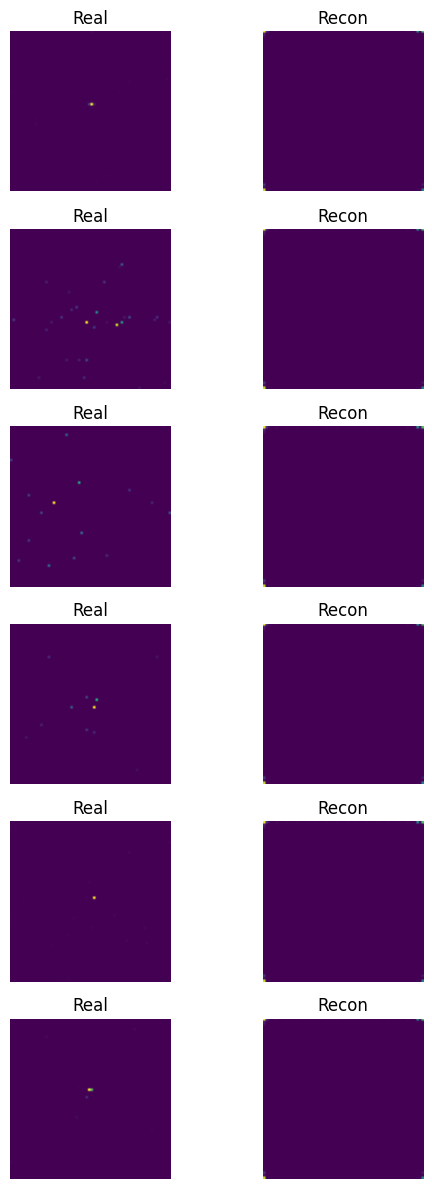

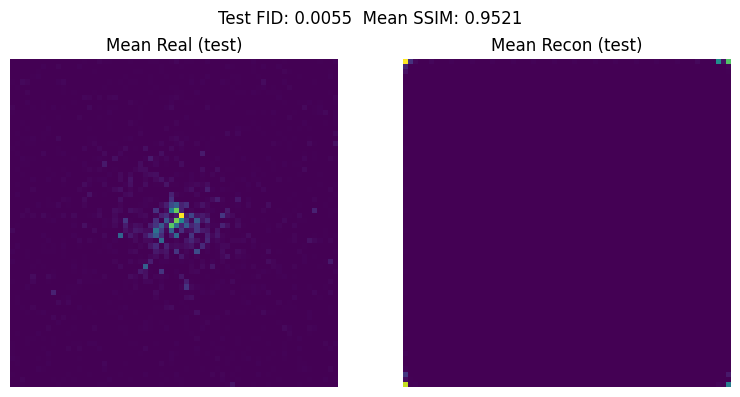

Saved test metrics and reconstructions.


In [15]:
# --- Unseen test set evaluation: FID & SSIM between reconstructions and originals ---
n_test = 100 
test_filename = f"data/QG{QG_channel}_64x64_1k"
test_X = None
with h5py.File(test_filename, 'r') as f:
    total_N = f['X'].shape[0]
    # prefer a chunk after the training subset if available
    if total_N > num_samples:
        start = num_samples
        end = min(start + n_test, total_N)
        test_X = np.array(f['X'][start:end])
    else:
        print('File does not contain extra samples beyond training subset; falling back to validation set as test.')
        # will use val_X as test below
        test_X = None

if test_X is not None and test_X.size>0:
    # Ensure shape (N,H,W,C)
    if test_X.ndim == 3:
        test_X = test_X[..., np.newaxis]
    # Normalize using training scale if available, else using test stats
    try:
        _minv = minv
        _maxv = maxv
    except NameError:
        _minv = test_X.min()
        _maxv = test_X.max()
    if _maxv - _minv > 0:
        test_X = (test_X - _minv) / (_maxv - _minv)
    test_t = torch.tensor(test_X).permute(0,3,1,2).float().to(device)
    # Run through model to get reconstructions
    model.eval()
    recon_test_list = []
    with torch.no_grad():
        for i in range(0, len(test_t), batch_size):
            batch = test_t[i:i+batch_size]
            pred = model(batch).cpu()
            recon_test_list.append(pred)
    recon_test = torch.cat(recon_test_list, dim=0).numpy().transpose(0,2,3,1)  # (N,H,W,C)
    real_test = test_t.cpu().numpy().transpose(0,2,3,1)
else:
    # fallback to using val_X (already preprocessed tensor)
    print('Using validation set as unseen test.')
    real_test = val_X.cpu().numpy().transpose(0,2,3,1)
    model.eval()
    with torch.no_grad():
        recon_test = model(val_X.to(device)).cpu().numpy().transpose(0,2,3,1)

# Trim to n_test if larger
m = min(len(real_test), n_test)
real_test = real_test[:m]
recon_test = recon_test[:m]

# Compute FID on unseen test set
mu_r, sig_r = calculate_statistics(real_test)
mu_g, sig_g = calculate_statistics(recon_test)
fid_test = calculate_fid(mu_r, sig_r, mu_g, sig_g)

# SSIM (mean across channels)
ssim_scores = []
for i in range(m):
    real_gray = np.mean(real_test[i], axis=2)
    recon_gray = np.mean(recon_test[i], axis=2)
    data_range = max(real_gray.max()-real_gray.min(), recon_gray.max()-recon_gray.min(), 1e-8)
    s = ssim_func(real_gray, recon_gray, data_range=float(data_range))
    ssim_scores.append(s)
mean_ssim_test = float(np.mean(ssim_scores)) if len(ssim_scores)>0 else float('nan')

print(f'Test FID: {fid_test:.4f}, Test Mean SSIM: {mean_ssim_test:.4f}')

# Visualize a few test pairs and mean images
n_display = min(6, m)
fig, axs = plt.subplots(n_display, 2, figsize=(6, 2*n_display))
for i in range(n_display):
    axs[i,0].imshow(np.mean(real_test[i], axis=2), cmap='viridis')
    axs[i,0].set_title('Real')
    axs[i,0].axis('off')
    axs[i,1].imshow(np.mean(recon_test[i], axis=2), cmap='viridis')
    axs[i,1].set_title('Recon')
    axs[i,1].axis('off')
plt.tight_layout()
plt.savefig('plots/test_real_vs_recon.png', dpi=150)
plt.show()

# Mean images side-by-side
mean_real_test = np.mean(real_test, axis=0)
mean_recon_test = np.mean(recon_test, axis=0)
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].imshow(np.mean(mean_real_test, axis=2), cmap='viridis')
axs[0].set_title('Mean Real (test)')
axs[0].axis('off')
axs[1].imshow(np.mean(mean_recon_test, axis=2), cmap='viridis')
axs[1].set_title('Mean Recon (test)')
axs[1].axis('off')
plt.suptitle(f'Test FID: {fid_test:.4f}  Mean SSIM: {mean_ssim_test:.4f}')
plt.tight_layout()
plt.savefig('plots/test_mean_and_metrics.png', dpi=150)
plt.show()

# Save metrics and reconstructions
os.makedirs('saved_models', exist_ok=True)
metrics = {'test_fid': float(fid_test), 'test_mean_ssim': float(mean_ssim_test), 'n_test': m}
with open('saved_models/classical_unet_test_metrics.json','w') as mf:
    json.dump(metrics, mf)
np.save('saved_models/classical_unet_test_reconstructions.npy', recon_test)
print('Saved test metrics and reconstructions.')